## Variationnal Auto-Encoder for spectral data compression and analysis.

We will be using pytorch to create an auto-encoder module.

In [1]:
%matplotlib widget

from torch import tanh, relu, Tensor, log_softmax
from torch.nn.functional import nll_loss
import torch
from torch.nn import Module, Linear, Dropout, Conv1d, MSELoss, LeakyReLU

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import numpy as np, matplotlib.pyplot as plt, toolkit.preprocessing as pp

In [2]:
class VariationalAutoEncoder(Module):
    def __init__(self, in_features, latent_features, complexity=2, smoothing=15):
        super().__init__()
        self.latent_features, self.in_features = latent_features, in_features
        self.smoothing = smoothing
        # The layers
        #self.conv1 = Conv1d(in_channels=1, out_channels=2, kernel_size=5)
        #self.enc1 = Linear(in_features=2*(in_features-5+1), out_features=512)#
        sl1 = complexity*128
        sl2 = complexity*32
        self.enc1 = Linear(in_features=in_features,out_features=sl1)
        self.enc2 = Linear(in_features=sl1, out_features=sl2)
        # Mean and logvar
        self.enc3 = Linear(in_features=sl2, out_features=latent_features*2)
    
        self.dec1 = Linear(in_features=latent_features, out_features=sl1)
        self.dec2 = Linear(in_features=sl1, out_features=sl2)
        self.dec3 = Linear(in_features=sl2, out_features=in_features+self.smoothing-1)
        #self.dec3 = Linear(in_features=64, out_features=in_features)
        
        self.conv2 = Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

    def encode(self, X):
        X = X if isinstance(X, Tensor) else Tensor(X)
        #X = self.do1(X)
        #X = self.conv1(X.reshape((X.shape[0], 1, -1))).reshape((-1,2*(self.in_features-5+1))) # 4298 4302
        X = LeakyReLU()(self.enc1(X))
        #X = self.do2(X)
        X = LeakyReLU()(self.enc2(X))
        X = self.enc3(X).view(-1, 2, self.latent_features)
        mu = X[:, 0, :] # the first feature values as mean
        log_var = X[:, 1, :] # the other feature values as variance
        return mu, log_var
    
    def decode(self, X):
        X = X if isinstance(X, Tensor) else Tensor(X)
        Y = LeakyReLU()(self.dec1(X))
        Y = LeakyReLU()(self.dec2(Y))
        Y = self.dec3(Y)
        Y = Y.view(-1, 1, self.in_features+self.smoothing-1)
        Y = self.conv2(Y)
        Y = Y.view(-1, self.in_features)
        return Y
    def forward(self, X):
        X = X if isinstance(X, Tensor) else Tensor(X)
        mu, log_var = self.encode(X)
        X = self.reparameterize(mu, log_var)
        Y = self.decode(X)
        return Y, mu, log_var

    def fit(self, loader, opt):
        self.train()
        running_loss = 0.0
        num_batches = 0
        for batch in loader:
            data = batch[0]
            opt.zero_grad()
            reconstruction, mu, logvar = self(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar, kld_weight=0.005) / len(data)
            running_loss += loss.item()
            num_batches += 1
            loss.backward()
            opt.step()
        train_loss = running_loss / float(num_batches)
        return train_loss
def final_loss(bce_loss, mu, logvar, kld_weight=0.005):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kld_weight * KLD

In [3]:
X_orig = np.load("./db/parchments_x_new.npy")[:,:,:]
fig, axs = plt.subplots(1,2,figsize=(9,3))
for i in range(X_orig.shape[0]):
    axs[0].plot(X_orig[i,:,::2].flatten())
scaler = pp.MeanMinMaxScaler()
X = scaler.fit_transform(X_orig)
for i in range(X.shape[0]):
    axs[1].plot(X[i,:,::2].flatten())


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
criterion = MSELoss(reduction="sum")
from tqdm import trange
def train(bs, llr, cmpl,smoothing, latent=2):
    vae = VariationalAutoEncoder(X.shape[2]*2, latent, complexity=cmpl, smoothing=smoothing)
    opt = Adam(vae.parameters(), lr=10**llr)
    epochs = 1000
    bs = int(bs)
    train_loader = DataLoader(TensorDataset(Tensor(X.reshape(X.shape[0], -1))), batch_size=bs, shuffle=True)
    progress = trange(epochs)
    train_loss = []
    for epoch in progress:
        train_epoch_loss = vae.fit(train_loader, opt)
        train_loss.append(train_epoch_loss)
        progress.set_description(f"epoch: {epoch} | loss: {round(train_epoch_loss,5)}.")
    return train_loss, vae

def fitness(params):
    tl, _ = train(*params)
    res = np.min(tl)
    if  res == np.nan or res == np.inf or not (res > 0 and res < 1e3) :
        return 1e3
    else:
        return res

import time
    

In [ ]:
from skopt import gbrt_minimize
from skopt.space import Integer, Real
space = [Integer(4, 32), Real(-4, -2), Integer(1, 4), Integer(5, 21)]
start = time.time()
res = gbrt_minimize(fitness, space, n_calls=100)
stop = time.time()
print(stop-start)

In [25]:
import pickle,os
if not os.path.isfile("optimized.obj"):
    with open("optimized.obj", "wb") as f:
        pickle.dump(res, f)
else:
    with open("optimized.obj", "rb") as f:
        res = pickle.load(f)
print(*res.x)
config = [23, -2.553545226043065, 2, 11]
#tl, vae = train(*res.x)
#torch.save(vae, "VAE.model")
#scaler.dump("VAE.scaler")
#tl, vae = train(*config)
vae = torch.load("VAE.model")

23 -2.553545226043065 2 11


In [26]:
plt.semilogy(tl,label="Fidelity")
plt.legend()
np.min(tl)

0.00011741915957166135

In [6]:
Y = np.load("./db/parchments_y_new.npy")

datas  = X.reshape(X.shape[0], -1)
mu, logvar = vae.encode(datas)
mu = mu.detach().numpy()
logvar = logvar.detach().numpy()
sig = np.exp(0.5 * logvar)
vae.eval()

VariationalAutoEncoder(
  (enc1): Linear(in_features=4302, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=64, bias=True)
  (enc3): Linear(in_features=64, out_features=4, bias=True)
  (dec1): Linear(in_features=2, out_features=256, bias=True)
  (dec2): Linear(in_features=256, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=4312, bias=True)
  (conv2): Conv1d(1, 1, kernel_size=(11,), stride=(1,))
)

0
1
2


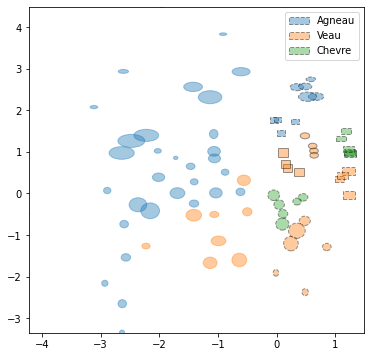

In [7]:
labels_animals = ["Agneau", "Veau", "Chevre"]
labels_country = ["UK", "DE", "Manuscripts"]

group = np.unique(Y[:,0])
from matplotlib.patches import Ellipse, Rectangle

fig, axs = plt.subplots(1,1,figsize=(6,6))
elems = []
for g in group:
    i = np.where(Y[:,0] == g)
    #axs.scatter(mu[i, 0], mu[i, 1], label=labels_animals[g], s=(2000*sig[i])**2,alpha=0.5)#
    print(g)
    for ii in i[0]:
        dpoint = None
        ls = "--" if Y[ii,1] == 0 else "-" # Dash is UK, line is DE
        if Y[ii,2] == 0: # Grain
            dpoint = Rectangle((mu[ii,0], mu[ii,1]), width=10*sig[ii,0] * 2, height=10*sig[ii,1] * 2, facecolor=f"C{g}", alpha=0.4,edgecolor='k',linestyle=ls)
        elif Y[ii,2] == 1: # Flesh
            dpoint = Ellipse((mu[ii,0], mu[ii,1]), width=10*sig[ii,0] * 2, height=10*sig[ii,1] * 2, facecolor=f"C{g}", alpha=0.4,linestyle=ls,edgecolor='k')
        else:
            dpoint = Ellipse((mu[ii,0], mu[ii,1]), width=10*sig[ii,0] * 2, height=10*sig[ii,1] * 2, color=f"C{g}", alpha=0.4)
        axs.add_patch(dpoint)
    elems.append(dpoint)
plt.axis([np.min(mu[:,0]),np.max(mu[:,0]),np.min(mu[:,1]),np.max(mu[:,1])])
plt.legend(elems, labels_animals)


In [7]:
#ii = 50
#datas  = X.reshape(X.shape[0], -1)
#mu, logvar = vae.encode(datas)
#mu = mu.detach().numpy()
#reconstructed = vae.decode(mu[ii,:]).detach().numpy().T
#l1, = plt.plot(reconstructed)
#plt.plot(datas[ii])

In [22]:
from __future__ import print_function
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import copy

In [23]:
display_model  = copy.deepcopy(vae)
display_model.eval()
datas  = X.reshape(X.shape[0], -1)
mudisp, logvardisp = display_model.encode(datas)
mudisp = mudisp.detach().numpy()
logvardisp = logvardisp.detach().numpy()
sigdisp = np.exp(0.5 * logvardisp)
wl = np.load("db/wl.npy")
reconstructed = display_model.decode(mudisp[0,:]).detach().numpy().T.reshape((1, 2,-1))
reconstructed = scaler.inverse_transform(reconstructed)


fig, axs = plt.subplots(1,1, figsize=(8,3))

l1, = axs.plot(wl, reconstructed[0, 1,:], 'k-.')
l2,  = axs.plot(wl, X_orig[0, 1,:], 'b-', alpha=0.6)
l3,l4 = axs.plot(wl, reconstructed[0, 0,:], wl, X_orig[0, 0,:])
#e1,e2 = axs[1].plot(wl, (reconstructed[0, 0,:]- X_orig[0, 0,:])/X_orig[0, 0,:], wl, (reconstructed[0, 1,:]- X_orig[0, 1,:])/X_orig[0, 1,:])
#axs[1].axis([0,2200,-3,3])

@widgets.interact(x=(0, 80, 1))
def f(x=1):
    reconstructed = display_model.decode(mudisp[x,:]).detach().numpy().T.reshape((1, 2,-1))
    reconstructed = scaler.inverse_transform(reconstructed)
    #axs.set_title(f"{mudisp[x,:]}")
    l1.set_ydata(reconstructed[0,1,:])
    l3.set_ydata(reconstructed[0,0,:]*20)
    l2.set_ydata(X_orig[x, 1,:])
    l4.set_ydata(X_orig[x, 0,:]*20)
    #e1.set_ydata(reconstructed[0, 0,:]- X_orig[x, 0,:]*5)
    #e2.set_ydata(reconstructed[0, 1,:]- X_orig[x, 1,:])
    return x
#axs.axis([wl.min(),wl.max(),0,100])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, description='x', max=80), Output()), _dom_classes=('widget-interact',…

In [24]:
## Compute spectral properties and map them to latent space
fig, axs = plt.subplots(1,1, figsize=(6,6))
from itertools import product
N = 100
i = np.where((wl < 500) & (wl > 0))
x = np.linspace(np.min(mu[:,0]),np.max(mu[:,0]), N)
y = np.linspace(np.min(mu[:,1]),np.max(mu[:,1]), N)
points = list(product(x,y))
xy = np.asarray(points).reshape(N**2,2)
reconstructed = vae.decode(xy).detach().numpy().reshape(N*N, 2, -1)
reconstructed = scaler.inverse_transform(reconstructed).reshape(N,N, 2, -1)
Z = np.mean(reconstructed[:, :, :, i],axis=-1)
print(Z.shape)
hi = plt.imshow(Z[:,:,1],extent=[x.min(), x.max(), y.min(), y.max()],vmin=Z.min(),vmax=Z.max())


studied_label = 1
group = np.unique(Y[:,studied_label])
for g in group:
    i = np.where(Y[:,studied_label] == g)
    axs.scatter(mu[i, 0], mu[i, 1], alpha=0.5)#
    
plt.axis("auto")
def f(x):
    minwl, maxwl = x
    i = np.where((wl < maxwl) & (wl > minwl))
    Z = np.mean(reconstructed[:, :, :, i],axis=-1)
    hi.set_data(Z[:,:,1])
    hi.set_clim(Z.min(), Z.max())
    
interact(f, x=widgets.IntRangeSlider(value=[700,1000], min=300, max=2300, step=10,continuous_update=False))
axs.set_title(f"Mean spectral content for [{700},{1000}] nm")
axs.set_xlabel("Coding variable I")
axs.set_ylabel("Coding variable II")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(100, 100, 2, 1)


interactive(children=(IntRangeSlider(value=(700, 1000), continuous_update=False, description='x', max=2300, mi…

Text(0, 0.5, 'Coding variable II')

## Classify from a 8-dim latent space

- Too much information is destroyed in 2D
- Information is well compressed with ~10D

In [10]:
import copy
from torch.nn import NLLLoss
class ClassificationModule(Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = copy.deepcopy(encoder)
        self.encoder.eval()
        self.lin1 = Linear(in_features=8, out_features=3)
        #self.lin2 = Linear(in_features=64, out_features=3)
    def forward(self, X):
        X = X if isinstance(X, Tensor) else Tensor(X)
        mu, logvar = self.encoder.encode(X)
        Y = log_softmax(self.lin1(mu), dim=-1)
        #Y = log_softmax(self.lin2(Y), dim=-1)
        return Y

In [11]:
## A new VAE for classification
tl, vae8 = train(8, -3.5, 2, 17, latent=8)
plt.figure()
plt.plot(tl)

epoch: 999 | loss: 0.33056.: 100%|██████████| 1000/1000 [01:31<00:00, 10.92it/s]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
model = ClassificationModule(vae8)
dataset = TensorDataset(torch.from_numpy(X.reshape(X.shape[0], -1)).float(), torch.from_numpy(Y[:,0]))
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
criterion_classif = NLLLoss()
optim = Adam(model.parameters(), lr=1e-3)

In [13]:
epochs = 200
progress = trange(epochs)
tl = []
for epoch in progress:
    epoch_loss = 0.0
    
    for batch, label in train_loader:
        optim.zero_grad()
        y_pred = model(batch)
        train_loss = criterion_classif(y_pred, label.long())
        train_loss.backward()
        optim.step()
        epoch_loss += train_loss.item()
    
    
    epoch_loss = epoch_loss / len(train_loader)
    tl.append(epoch_loss)
    progress.set_description(f"epoch: {epoch} | loss: {round(epoch_loss,5)}.")
plt.figure()
plt.plot(tl)
    #print(epoch_loss)
#clss = model.forward(xy).detach().numpy()
#plt.figure(figsize=(6,6))
#clss = clss.reshape(N,N,3)
#plt.imshow(np.flipud(np.argmax(clss,axis=-1).T),extent=[x.min(), x.max(), y.min(), y.max()])

#studied_label = 0
#group = np.unique(Y[:,studied_label])
#for g in group:
#    i = np.where(Y[:,studied_label] == g)
#    plt.scatter(mu[i, 0], mu[i, 1])#
#plt.axis("auto")
    

epoch: 199 | loss: 0.00012.: 100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
###### Represent the classification in 2D
fig, axs = plt.subplots(1,1, figsize=(8,6))
from itertools import product
N = 100
i = np.where((wl < 500) & (wl > 0))
x = np.linspace(np.min(mu[:,0]),np.max(mu[:,0]), N)
y = np.linspace(np.min(mu[:,1]),np.max(mu[:,1]), N)
points = list(product(x,y))
xy = np.asarray(points).reshape(N**2,2)
reconstructed = vae.decode(xy)
classifs = model.forward(reconstructed).reshape(N,N, 3).detach().numpy()
img = plt.imshow(np.flipud(np.argmax(classifs, axis=-1).T),extent=[x.min(), x.max(), y.min(), y.max()])


studied_label = 0
group = np.unique(Y[:,studied_label])
for g in group:
    i = np.where(Y[:,studied_label] == g)
    plt.scatter(mu[i, 0], mu[i, 1], alpha=0.5)
plt.title("Linear classification in the 8-dim latent space.")

axs.set_xlabel("Coding variable I")
axs.set_ylabel("Coding variable II")
axs.axis("auto")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-4.220639228820801,
 1.4815107583999634,
 -3.3525619506835938,
 4.493504047393799)